# 0. Load data

In [71]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import string
from collections import Counter
import nltk as nltk
from nltk.text import Text
import re
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from itertools import combinations
import matplotlib.pyplot as plt
from nltk import ngrams

In [72]:
# import data
import csv
df = pd.read_csv('Food_Inspections_20240108.csv')
df.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2587633,TACOS MARIO'S LIMITED,TACOS MARIO'S LIMITED,1447643.0,Restaurant,Risk 1 (High),4540 W 63RD ST,CHICAGO,IL,60629.0,01/04/2024,Non-Inspection,No Entry,NaN,41.778606,-87.736592,"(41.77860614662516, -87.73659163763277)"
1,2587625,"TAQUERIA EL ARCO #3 EL POLLO FELIZ, INC.",EL POLLO CRIS CRIS #3,1964458.0,Restaurant,Risk 1 (High),7023-7025 S PULASKI RD,CHICAGO,IL,60629.0,01/04/2024,Canvass,Out of Business,NaN,41.765126,-87.722279,"(41.765126421774134, -87.72227898862089)"
2,2587598,Tel Aviv Slices Pizza LLC,Tel Aviv Slices Pizza LLC,2948183.0,NaN,Risk 1 (High),3517 W DEVON AVE,CHICAGO,IL,60659.0,01/04/2024,License,Not Ready,NaN,41.997177,-87.717388,"(41.99717696905116, -87.71738760229222)"
3,2587596,KENSINGTON SCHOOL OF LINCOLN PARK,KENSINGTON SCHOOL OF LINCOLN PARK,2944036.0,Children's Services Facility,Risk 1 (High),2745 N LINCOLN AVE,CHICAGO,IL,60614.0,01/04/2024,License,Pass,NaN,41.931779,-87.657407,"(41.93177936843524, -87.65740695216547)"
4,2587599,Q'S AUTHENTIC COOKING,Q'S AUTHENTIC COOKING,2757521.0,Restaurant,Risk 1 (High),306 E 75TH ST,CHICAGO,IL,60619.0,01/04/2024,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.758467,-87.617974,"(41.75846743102775, -87.61797380173462)"
5,2587579,SUBWAY,SUBWAY,1719251.0,Restaurant,Risk 1 (High),10354 S HALSTED ST,CHICAGO,IL,60628.0,01/04/2024,Canvass,Out of Business,NaN,41.705296,-87.642931,"(41.705296492547895, -87.64293095094614)"
6,2587551,WE ARE THE FUTURE PRESIDENTS,WE ARE THE FUTURE PRESIDENTS,2578250.0,Daycare Above and Under 2 Years,Risk 1 (High),843-847 W 103RD ST,CHICAGO,IL,60643.0,12/29/2023,License,No Entry,NaN,41.706792,-87.644524,"(41.706792177425825, -87.64452365930406)"
7,2587527,ST. ANTHONY HOSPITAL,PATIENT KITCHEN/PREP AREA,2204412.0,Hospital,Risk 1 (High),2875 W 19TH ST,CHICAGO,IL,60623.0,12/29/2023,Canvass Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.855403,-87.698708,"(41.85540289350027, -87.69870754487314)"
8,2587465,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,Restaurant,Risk 1 (High),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,12/28/2023,Canvass,Out of Business,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)"
9,2587467,ICOLDTEA,ICOLDTEA,2886816.0,Restaurant,Risk 2 (Medium),1122 W WILSON AVE,CHICAGO,IL,60640.0,12/28/2023,Canvass,Out of Business,NaN,41.965497,-87.658403,"(41.965497036127346, -87.65840280954839)"


In [73]:
df.shape

(265653, 17)

# Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors

In [74]:
# Define a regular expression pattern to extract the comments
comment_pattern = r'Comments:\s*(.*?)(?=\s*\||$)'

# Apply the regular expression and create a new column with only the regulation descriptions
df['comments'] = df['Violations'].str.findall(comment_pattern)

# Display the DataFrame with the new column
df.head(60)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,comments
0,2587633,TACOS MARIO'S LIMITED,TACOS MARIO'S LIMITED,1447643.0,Restaurant,Risk 1 (High),4540 W 63RD ST,CHICAGO,IL,60629.0,01/04/2024,Non-Inspection,No Entry,NaN,41.778606,-87.736592,"(41.77860614662516, -87.73659163763277)",NaN
1,2587625,"TAQUERIA EL ARCO #3 EL POLLO FELIZ, INC.",EL POLLO CRIS CRIS #3,1964458.0,Restaurant,Risk 1 (High),7023-7025 S PULASKI RD,CHICAGO,IL,60629.0,01/04/2024,Canvass,Out of Business,NaN,41.765126,-87.722279,"(41.765126421774134, -87.72227898862089)",NaN
2,2587598,Tel Aviv Slices Pizza LLC,Tel Aviv Slices Pizza LLC,2948183.0,NaN,Risk 1 (High),3517 W DEVON AVE,CHICAGO,IL,60659.0,01/04/2024,License,Not Ready,NaN,41.997177,-87.717388,"(41.99717696905116, -87.71738760229222)",NaN
3,2587596,KENSINGTON SCHOOL OF LINCOLN PARK,KENSINGTON SCHOOL OF LINCOLN PARK,2944036.0,Children's Services Facility,Risk 1 (High),2745 N LINCOLN AVE,CHICAGO,IL,60614.0,01/04/2024,License,Pass,NaN,41.931779,-87.657407,"(41.93177936843524, -87.65740695216547)",NaN
4,2587599,Q'S AUTHENTIC COOKING,Q'S AUTHENTIC COOKING,2757521.0,Restaurant,Risk 1 (High),306 E 75TH ST,CHICAGO,IL,60619.0,01/04/2024,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.758467,-87.617974,"(41.75846743102775, -87.61797380173462)",[OBSERVED THE FLOORS BEHIND THE COOKING EQUIPM...
5,2587579,SUBWAY,SUBWAY,1719251.0,Restaurant,Risk 1 (High),10354 S HALSTED ST,CHICAGO,IL,60628.0,01/04/2024,Canvass,Out of Business,NaN,41.705296,-87.642931,"(41.705296492547895, -87.64293095094614)",NaN
6,2587551,WE ARE THE FUTURE PRESIDENTS,WE ARE THE FUTURE PRESIDENTS,2578250.0,Daycare Above and Under 2 Years,Risk 1 (High),843-847 W 103RD ST,CHICAGO,IL,60643.0,12/29/2023,License,No Entry,NaN,41.706792,-87.644524,"(41.706792177425825, -87.64452365930406)",NaN
7,2587527,ST. ANTHONY HOSPITAL,PATIENT KITCHEN/PREP AREA,2204412.0,Hospital,Risk 1 (High),2875 W 19TH ST,CHICAGO,IL,60623.0,12/29/2023,Canvass Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.855403,-87.698708,"(41.85540289350027, -87.69870754487314)",[EYE WASH STATION INSTALLED ON FAUCET OF HANDW...
8,2587465,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,Restaurant,Risk 1 (High),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,12/28/2023,Canvass,Out of Business,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)",NaN
9,2587467,ICOLDTEA,ICOLDTEA,2886816.0,Restaurant,Risk 2 (Medium),1122 W WILSON AVE,CHICAGO,IL,60640.0,12/28/2023,Canvass,Out of Business,NaN,41.965497,-87.658403,"(41.965497036127346, -87.65840280954839)",NaN


In [75]:
df.loc[47, 'comments']

["FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S TOILET ROOM WITHOUT HOT WATER. FOUND WATER TEMPERATURES RANGING FROM 80F - 85F. MUST PROVIDE HOT WATER TEMPERATURE OF 100F AT ALL TIMES. MUST REPAIR AND MAINTAIN. PRIORITY VIOLATION. 7-38-030(C).  CITATION ISSUED",
 'FOUND CITY OF CHICAGO FOOD SERVICE MANAGER WITHOUT PROOF OF ALLERGEN TRAINING ON SITE AT THE TIME OF INSPECTION. INSTRUCTED TO PROVIDE PROOF OF ALLERGEN TRAINING FOR ALL CITY OF CHICAGO FOOD SERVICE MANAGERS.']

# text pre-processing technique

In [76]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to clean and tokenize text
def process_text(text_list):
    if text_list is None or not isinstance(text_list, list):
        return np.nan

    # Combine the list elements into a single string
    text = ' '.join(str(element) for element in text_list if isinstance(element, str))

    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize words
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the processed tokens back into a string
    processed_text = " ".join(tokens)
    return processed_text

In [77]:
# Apply text processing to 'comments' column
df['cleaned comments'] = df['comments'].apply(process_text)
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,comments,cleaned comments
0,2587633,TACOS MARIO'S LIMITED,TACOS MARIO'S LIMITED,1447643.0,Restaurant,Risk 1 (High),4540 W 63RD ST,CHICAGO,IL,60629.0,01/04/2024,Non-Inspection,No Entry,NaN,41.778606,-87.736592,"(41.77860614662516, -87.73659163763277)",NaN,NaN
1,2587625,"TAQUERIA EL ARCO #3 EL POLLO FELIZ, INC.",EL POLLO CRIS CRIS #3,1964458.0,Restaurant,Risk 1 (High),7023-7025 S PULASKI RD,CHICAGO,IL,60629.0,01/04/2024,Canvass,Out of Business,NaN,41.765126,-87.722279,"(41.765126421774134, -87.72227898862089)",NaN,NaN
2,2587598,Tel Aviv Slices Pizza LLC,Tel Aviv Slices Pizza LLC,2948183.0,NaN,Risk 1 (High),3517 W DEVON AVE,CHICAGO,IL,60659.0,01/04/2024,License,Not Ready,NaN,41.997177,-87.717388,"(41.99717696905116, -87.71738760229222)",NaN,NaN
3,2587596,KENSINGTON SCHOOL OF LINCOLN PARK,KENSINGTON SCHOOL OF LINCOLN PARK,2944036.0,Children's Services Facility,Risk 1 (High),2745 N LINCOLN AVE,CHICAGO,IL,60614.0,01/04/2024,License,Pass,NaN,41.931779,-87.657407,"(41.93177936843524, -87.65740695216547)",NaN,NaN
4,2587599,Q'S AUTHENTIC COOKING,Q'S AUTHENTIC COOKING,2757521.0,Restaurant,Risk 1 (High),306 E 75TH ST,CHICAGO,IL,60619.0,01/04/2024,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.758467,-87.617974,"(41.75846743102775, -87.61797380173462)",[OBSERVED THE FLOORS BEHIND THE COOKING EQUIPM...,observed floor behind cooking equipment ventil...


In [78]:
df.loc[43, 'comments']

['PREVIOUS PRIORITY FOUNDATION NOT CORRECTED FROM 12/8/23 REPORT 2586583 NOT CORRECTED. 14- NO WRITTEN AGREEMENT OR STATEMENT FROM THE SUPPLIER STATING THE FISH/SEAFOOD SUPPLIED FOR SUSHI IS FROZEN TO THE REQUIRED TIME AND TEMPERATURE. INSTD TO PROVIDE THE SAME AND MAINTAIN VERIFICATION ON-SITE. CITATION ISSUED 7-42-090 PRIORITY']

In [79]:
df.loc[43, 'cleaned comments']

'previous priority foundation corrected 12823 report 2586583 corrected 14 written agreement statement supplier stating fishseafood supplied sushi frozen required time temperature instd provide maintain verification onsite citation issued 742090 priority'

# Explain why you selected a particular text pre-processing technique

Before delving into model building, a series of text pre-processing techniques were executed to optimize the input data for enhanced model performance. The sequential steps involved in this process are as follows:

First of all, the entire text corpus was converted to lowercase. This standardization facilitates case-insensitive matching, promoting consistency across the dataset. 
And then we decided to eliminate punctuation characters from the text because punctuation typically does not carry much information and can be safely removed to simplify the text without losing important content.
For analysis purpose, we also split the text into individual words (tokens), enabling a granular examination of the text.
After tokenizing the text, we further removed common English stopwords from the tokenized list, because stopwords are words that are frequently used in a language but often do not contribute much to the meaning of a text. Removing them can reduce noise in the data and improve the efficiency of downstream analyses. 
Finally, we applied lemmatization to the tokens. This process reduced words to their base or root form, fostering standardization. The resultant effect is an improvement in model performance by curbing the dimensionality of the feature space.

# Build a classification model, predicting the outcome of inspection – comments are predictors, target variable is “Results” column

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['comments'], df['Results'], test_size=0.2, random_state=42)


## Naive Bayes

In [81]:
# Drop rows with missing values in the relevant columns
df = df.dropna(subset=['comments', 'Results'])

# Flatten the lists within 'comments' column
df['comments'] = df['comments'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

# Convert comments to TF-IDF features
if df['comments'].dtype != 'object':
    df['comments'] = df['comments'].astype(str)

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['comments'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['Results'], test_size=0.2, random_state=42)

# Train a classifier (Naive Bayes as an example)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                     precision    recall  f1-score   support

              Fail       0.79      0.69      0.74      9767
          No Entry       0.00      0.00      0.00       124
         Not Ready       0.00      0.00      0.00        13
   Out of Business       0.00      0.00      0.00         9
              Pass       0.92      0.96      0.93     20633
Pass w/ Conditions       0.70      0.75      0.73      8018

          accuracy                           0.84     38564
         macro avg       0.40      0.40      0.40     38564
      weighted avg       0.84      0.84      0.84     38564

Accuracy: 0.84


/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


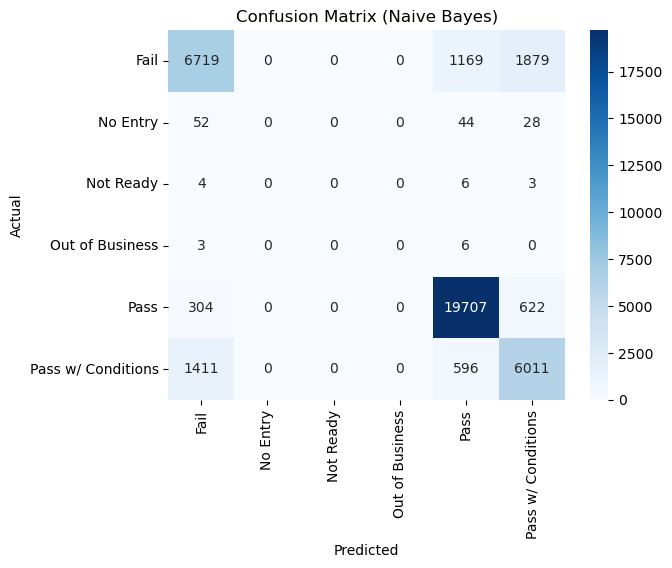

In [82]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Naive Bayes
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
                     precision    recall  f1-score   support

              Fail       0.90      0.85      0.87      9767
          No Entry       0.13      0.06      0.09       124
         Not Ready       0.23      0.23      0.23        13
   Out of Business       0.00      0.00      0.00         9
              Pass       0.97      0.99      0.98     20633
Pass w/ Conditions       0.87      0.87      0.87      8018

          accuracy                           0.93     38564
         macro avg       0.52      0.50      0.51     38564
      weighted avg       0.93      0.93      0.93     38564

Accuracy: 0.93


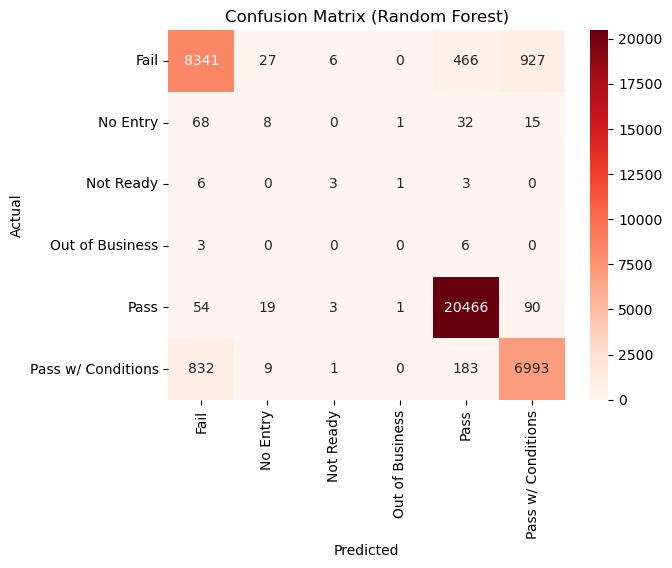

In [84]:
# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize results of at least two text classifiers and select the most robust one

Upon examining the classification reports and Confusion Matrices for both the Naive Bayes and Random Forest models, we observed notable distinctions. The Random Forest model demonstrated a superior performance with an accuracy of 93%, surpassing the 84% accuracy achieved by the Naive Bayes model.

While both models exhibited impressive accuracy in predicting the majority of data labeled as "Fail," "Pass," and "Pass w/ Conditions," the Random Forest model excelled further by demonstrating capability in handling minority cases such as "No Entry" and "Not Ready."

Considering the comprehensive evaluation of accuracy and effectiveness across various classifiers, we concluded that the Random Forest model stands out as the most robust choice for this specific scenario.